In [30]:
import pandas as pd
import numpy as np

# Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [15]:
train = pd.read_csv('Fake_News_Classifier/train.csv')
test = pd.read_csv('Fake_News_Classifier/test.csv')
submit = pd.read_csv('Fake_News_Classifier/submit.csv')

In [16]:
print(train.shape, test.shape, submit.shape)

(20800, 5) (5200, 4) (5200, 2)


**NOTE** - Labels of test.csv are present in submit.csv file grouped by their **id**.

**test.csv** contains test data without labels. Labels for **test.csv** are present in **submit.csv**. Here, we will split our **train.csv** file to separate train and test sets and treat **test.csv** as unknown file for measuring the final perfomance of our model. Lets concatenate submit.csv columnwise on test.csv.

In [17]:
test = pd.merge(test, submit, on="id")
test.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [18]:
### Distribution of the label column in train
train['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

So we have quite a balanced distribution of **fake** and **real** news in our training set.

In [19]:
### Exploring the 'title' column
### Lets see how different the title of a fake news is that from a real news
fake_news = train[train['label']==1]['title']
print('Fake News:\n', fake_news[:5])
print('='*60) # Separator
real_news = train[train['label']==0]['title']
print('Real News:\n', real_news[:5])

Fake News:
 0    House Dem Aide: We Didn’t Even See Comey’s Let...
2                    Why the Truth Might Get You Fired
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
6    Life: Life Of Luxury: Elton John’s 6 Favorite ...
Name: title, dtype: object
Real News:
 1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
5    Jackie Mason: Hollywood Would Love Trump if He...
7    Benoît Hamon Wins French Socialist Party’s Pre...
8    Excerpts From a Draft Script for Donald Trump’...
9    A Back-Channel Plan for Ukraine and Russia, Co...
Name: title, dtype: object


In [20]:
### Lets see how many unique authors are presnt in the news articles collected in training set
print(len(train['author'].unique()))

4202


In [21]:
print(train.isnull().sum(), test.isnull().sum(), sep='\n\n')

id           0
title      558
author    1957
text        39
label        0
dtype: int64

id          0
title     122
author    503
text        7
label       0
dtype: int64


**NOTE** - A lot of values from the **author** column are missing in both the train and test set.

So among the 20,800-1957= 18,843 authors present in the training set, there are only 4202 unique authors.= i.e. a ratio of 1:4.

In [22]:
### lets seggregate the classes into fake and real and see the unique aiuthors in each class.
fake_news_author = train[train['label']==1]['author']
real_news_author = train[train['label']==0]['author']
print('Number of authors in fake news aricles:', len(fake_news_author.unique()))
print('Number of authors in real news aricles:', len(real_news_author.unique()))

Number of authors in fake news aricles: 1982
Number of authors in real news aricles: 2226


Outcome ----> not drastically different results. Since we are classifying fake/real news, it will mainly depend upon **title** and **text** of the news. The column **author** will have minimal impact on the outcome of the text prediction. So. lets drop the column **author** from the train and test sets altogether.

In [23]:
train.drop(columns='author', inplace=True)
test.drop(columns='author', inplace=True)
test.head()

,id,title,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...","PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...","If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


TypeError: sequence item 23: expected str instance, float found

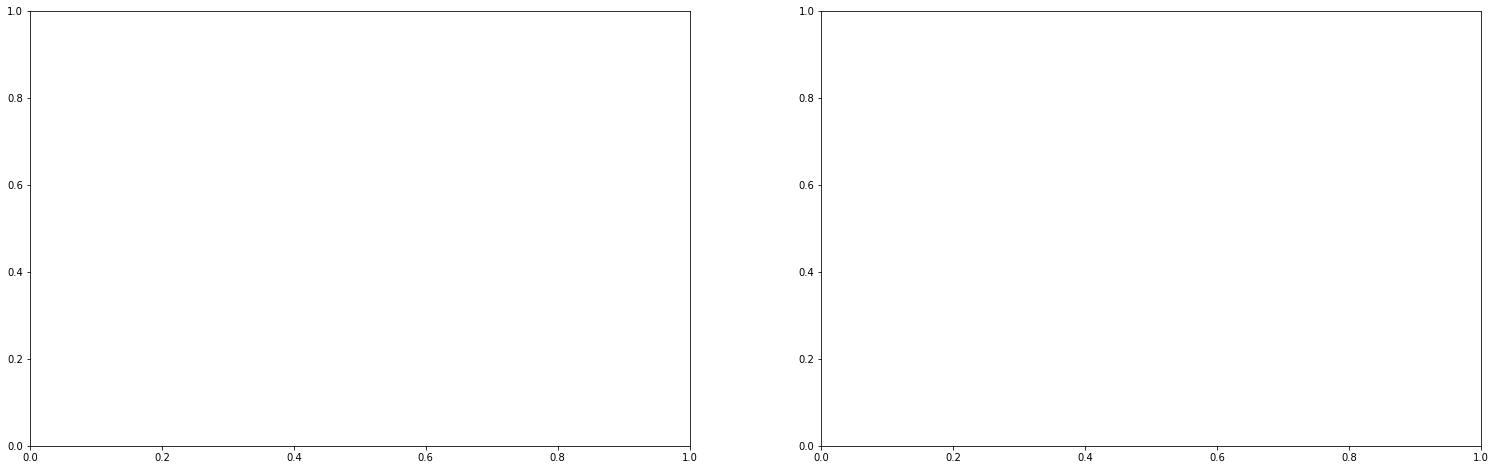

In [44]:
### Just for the fun of it, lets create a wordcloud for the title of fake news and real news using their most common words separately.
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(fake_news))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(real_news))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [24]:
### lets replace the missing values in remaining columns (both in train and test) with a SPACE
train = train.fillna(' ')
test = test.fillna(' ')
print(train.isnull().sum(), test.isnull().sum(), sep='\n\n')

id       0
title    0
text     0
label    0
dtype: int64

id       0
title    0
text     0
label    0
dtype: int64


### Confusion Matrix Function

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Classify based on News Content

In [25]:
# Applying text-preprocessing methods

def clean_text(text):
    '''
    
    1- Make text lowercase. 
    2- Remove any character apart from alphabets. 
    3- Tokenize sentence into words
    4- Removing any stopwords present in english language
    5- Stemming/Lemmatization
    6- Joining the tokens obtained after stemming/lemmatization 
    
    '''
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = nltk.word_tokenize(text)
    ps = PorterStemmer()
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word) 
            for word in text
            if word not in set(stopwords.words('english'))]
    text = " ". join(text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    house dem aide even see comey letter jason cha...
1    ever get feeling life circle roundabout rather...
2    truth might get fired october tension intellig...
3    video civilian killed single u airstrike ident...
4    print iranian woman sentenced six year prison ...
Name: text, dtype: object

In [32]:
cv = CountVectorizer()
tfidf = TfidfVectorizer() # Need to optimize ngram_range
train_cv = cv.fit_transform(train['text'])
test_cv = cv.transform(test['text'])
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

In [35]:
train_cv

<20800x136428 sparse matrix of type '<class 'numpy.int64'>'
	with 5345240 stored elements in Compressed Sparse Row format>

## Text Classification Model 

### Multinomial Naive Bayes

In [36]:
mNB = MultinomialNB()
mNB.fit(train_cv , train['label'])
ypred_cv = mNB.predict(test_cv)

mNB.fit(train_tfidf, train['label'])
ypred_tfidf = mNB.predict(test_tfidf)

In [37]:
accuracy_cv = accuracy_score(ypred_cv, test['label'])
accuracy_tfidf = accuracy_score(ypred_tfidf, test['label'])
print('Accuracy using bag of words:', accuracy_cv)
print('Accuracy using TfIdfVectorizer:', accuracy_tfidf)

Accuracy using bag of words: 0.5951923076923077
Accuracy using TfIdfVectorizer: 0.5934615384615385


### XGBoost

In [38]:
import xgboost as xgb
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

xgb.fit(train_cv, train['label'])
ypred_cv = xgb.predict(test_cv)

xgb.fit(train_tfidf, train['label'])
ypred_tfidf = xgb.predict(test_tfidf)

In [39]:
accuracy_cv = accuracy_score(ypred_cv, test['label'])
accuracy_tfidf = accuracy_score(ypred_tfidf, test['label'])
print('Accuracy using bag of words:', accuracy_cv)
print('Accuracy using TfIdfVectorizer:', accuracy_tfidf)

Accuracy using bag of words: 0.64
Accuracy using TfIdfVectorizer: 0.6394230769230769


# Classify based on News Headlines

In [40]:
# Applying the cleaning function to both test and training datasets
train['title'] = train['title'].apply(lambda x: clean_text(x))
test['title'] = test['title'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['title'].head()

0    house dem aide even see comey letter jason cha...
1     flynn hillary clinton big woman campus breitbart
2                                truth might get fired
3        civilian killed single u airstrike identified
4    iranian woman jailed fictional unpublished sto...
Name: title, dtype: object

In [42]:
cv = CountVectorizer()
tfidf = TfidfVectorizer() # Need to optimize ngram_range
train_cv = cv.fit_transform(train['title'])
test_cv = cv.transform(test['title'])
train_tfidf = tfidf.fit_transform(train['title'])
test_tfidf = tfidf.transform(test['title'])

## Title Classification Model

### Multinomial Naive Bayes

In [43]:
mNB = MultinomialNB()
mNB.fit(train_cv, train['label'])
ypred_cv = mNB.predict(test_cv)

mNB.fit(train_tfidf, train['label'])
ypred_tfidf = mNB.predict(test_tfidf)

In [44]:
accuracy_cv = accuracy_score(ypred_cv, test['label'])
accuracy_tfidf = accuracy_score(ypred_tfidf, test['label'])
print('Accuracy using bag of words:', accuracy_cv)
print('Accuracy using TfIdfVectorizer:', accuracy_tfidf)

Accuracy using bag of words: 0.6334615384615384
Accuracy using TfIdfVectorizer: 0.6151923076923077


### XGBoost

In [45]:
import xgboost as xgb
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

xgb.fit(train_cv, train['label'])
ypred_cv = xgb.predict(test_cv)

xgb.fit(train_tfidf, train['label'])
ypred_tfidf = xgb.predict(test_tfidf)

In [46]:
accuracy_cv = accuracy_score(ypred_cv, test['label'])
accuracy_tfidf = accuracy_score(ypred_tfidf, test['label'])
print('Accuracy using bag of words:', accuracy_cv)
print('Accuracy using TfIdfVectorizer:', accuracy_tfidf)

Accuracy using bag of words: 0.6775
Accuracy using TfIdfVectorizer: 0.6778846153846154
